Data shape: (150, 4)
Length of labels: 150
1/2
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 57, 60, 67, 69, 79, 80, 81, 93, 98], 1: [50, 51, 52, 54, 58, 62, 63, 65, 68, 71, 72, 73, 74, 75, 76, 77, 83, 86, 87, 91, 92, 97, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 137, 139, 140, 141, 143, 144, 145, 146, 147], 2: [53, 55, 56, 59, 61, 64, 66, 70, 78, 82, 84, 85, 88, 89, 90, 94, 95, 96, 99, 100, 101, 106, 113, 114, 115, 121, 127, 136, 138, 142, 148, 149]}
2/2
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 1: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7

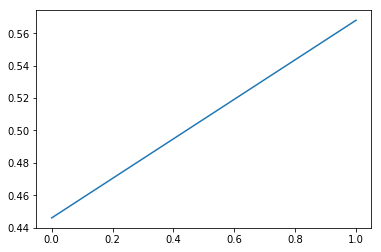

In [6]:
#导入所需的库
import numpy as np
import time
import random 
from scipy.special import comb
import matplotlib.pyplot as plt
%matplotlib inline


#定义加载数据的函数，这里以鸢尾花数据集为例
def load_data(file):
    '''
    INPUT:
    file - (str) 数据文件的路径
    
    OUTPUT:
    Xarray - (array) 特征数据数组
    Ylist - (list) 类别标签列表
    
    '''
    Xlist = []  #定义一个列表用来保存每条数据
    Ylist = []  #定义一个列表用来保存每条数据的类别标签
    fr = open(file)
    for line in fr.readlines():  #逐行读取数据，鸢尾花数据集每一行表示一个鸢尾花的特征和类别标签，用逗号分隔
        cur = line.split(',')
        label = cur[-1]
        X = [float(x) for x in cur[:-1]]  #用列表来表示一条特征数据
        Xlist.append(X)
        Ylist.append(label)
    Xarray = np.array(Xlist)  #将特征数据转换为数组类型，方便之后的操作
    print('Data shape:', Xarray.shape)
    print('Length of labels:', len(Ylist))
    return Xarray, Ylist


#定义标准化函数，对每一列特征进行min-max标准化，将数据缩放到0-1之间
#标准化处理对于计算距离的机器学习方法是非常重要的，因为特征的尺度不同会导致计算出来的距离倾向于尺度大的特征，为保证距离对每一列特征都是公平的，必须将所有特征缩放到同一尺度范围内
def Normalize(Xarray):
    '''
    INPUT:
    Xarray - (array) 特征数据数组
    
    OUTPUT:
    Xarray - (array) 标准化处理后的特征数据数组
    
    '''
    for f in range(Xarray.shape[1]):
        maxf = np.max(Xarray[:, f])
        minf = np.min(Xarray[:, f])
        for n in range(Xarray.shape[0]):
            Xarray[n][f] = (Xarray[n][f]-minf) / (maxf-minf) 
    return Xarray


#定义计算两条数据间的距离的函数，这里计算的是欧式距离
def cal_distance(xi, xj):
    '''
    INPUT:
    Xi - (array) 第i条特征数据
    Xj - (array) 第j条特征数据
    
    OUTPUT:
    dist - (float) 两条数据的欧式距离
    
    '''
    dist = 0
    for col in range(len(xi)):
        dist += (xi[col]-xj[col]) ** 2
    return dist


#定义计算类中心的函数，以当前类中所包含数据的各个特征均值作为新的新的类中心
def cal_groupcenter(group, Xarray):
    '''
    INPUT:
    group - (list) 类所包含的数据列表
    Xarray - (array) 特征数据数组
    
    OUTPUT:
    center - (array) 新的类中心
    
    '''
    center = np.zeros(Xarray.shape[1])
    for i in range(Xarray.shape[1]):
        for n in group:
            center[i] += Xarray[n][i]  #计算当前类中第i个特征的数据之和
    center = center / Xarray.shape[0]  #计算各个特征的均值
    return center


#定义计算调整兰德系数(ARI)的函数，调整兰德系数是一种聚类方法的常用评估方法
def Adjusted_Rand_Index(group_dict, Ylist, k):
    '''
    INPUT:
    group_dict - (dict) 类别字典
    Ylist - (list) 类别标签列表
    k - (int) 设定的类别数
    
    OUTPUT:
    (int) 调整兰德系数
    
    '''
    group_array = np.zeros((k, k))  #定义一个数组，用来保存聚类所产生的类别标签与给定的外部标签各类别之间共同包含的数据数量
    ylabel = list(set(Ylist))  #Ylist保存的标签为字符串，用ylabel来保存各个标签，在y_dict中类别以标签在ylabel列表中的索引值来表示类
    y_dict = {i:[] for i in range(k)}  #定义一个空字典，用来保存外部标签中各类所包含的数据，结构与group_dict相同
    for i in range(len(Ylist)):
        y_dict[ylabel.index(Ylist[i])].append(i)
    #循环计算group_array的值
    for i in range(k):
        for j in range(k):
            for n in range(len(Ylist)):
                if n in group_dict[i] and n in y_dict[j]:
                    group_array[i][j] += 1  #如果数据n同时在group_dict的类别i和y_dict的类别j中，group_array[i][j]的数值加一
    RI = 0  #定义兰德系数(RI)
    sum_i = np.zeros(3)  #定义一个数组，用于保存聚类结果group_dict中每一类的个数
    sum_j = np.zeros(3)  #定义一个数组，用于保存外部标签y_dict中每一类的个数
    for i in range(k):
        for j in range(k):
            sum_i[i] += group_array[i][j]
            sum_j[j] += group_array[i][j]
            if group_array[i][j] >= 2:
                RI += comb(group_array[i][j], 2)  #comb用于计算group_array[i][j]中两两组合的组合数
    ci = 0  #ci保存聚类结果中同一类中的两两组合数之和
    cj = 0  #cj保存外部标签中同一类中的两两组合数之和
    for i in range(k):
        if sum_i[i] >= 2:
            ci += comb(sum_i[i], 2)
    for j in range(k):
        if sum_j[j] >= 2:
            cj += comb(sum_j[j], 2)
    E_RI = ci * cj / comb(len(Ylist), 2)  #计算RI的期望
    max_RI = (ci + cj) / 2  #计算RI的最大值
    return (RI-E_RI) / (max_RI-E_RI)  #返回调整兰德系数的值


#定义k均值聚类函数
def Kmeans(Xarray, k, iters):
    '''
    INPUT:
    Xarray - (array) 特征数据数组
    k - (int) 设定的类别数
    iters - (int) 设定的迭代次数
    
    OUTPUT:
    group_dict - (dict) 类别字典
    scores - (int) 每次迭代的ARI得分列表
    
    '''
    center_inds = random.sample(range(Xarray.shape[0]), k)  #从特征数据中随机抽取k个数据索引
    centers = [Xarray[ci] for ci in center_inds]  #将这k个数据索引所对应的特征数据作为初始的k个聚类中心
    scores = []  #定义一个空列表用来保存每次迭代的ARI得分
    for i in range(iters):
        group_dict = {i:[] for i in range(k)}  #定义一个空字典，用于保存聚类所产生的所有类别，其中字典的键为类别标签，值为类别所包含的数据列表，以索引表示每条数据
        print('{}/{}'.format(i+1, iters))
        #循环计算每条数据到各个聚类中心的距离
        for n in range(Xarray.shape[0]):
            dists = []  #保存第n条数据到各个聚类中心的距离
            for ci in range(k):
                dist = cal_distance(Xarray[n], centers[ci])
                dists.append(dist)
            g = dists.index(min(dists))  #取距离最近的中心所在的类
            group_dict[g].append(n)  #将第n条数据的索引n保存到g类
        print(group_dict)
        for i in range(k):
            centers[i] = cal_groupcenter(group_dict[i], Xarray)  #根据每一类所包含的数据重新计算类中心
        scores.append(Adjusted_Rand_Index(group_dict, Ylist, k))  #将该轮迭代的ARI得分保存到scores列表
    return group_dict, scores


if __name__ == "__main__":
    Xarray, Ylist = load_data('..\iris.data')  #加载数据
    start = time.time()  #保存开始时间
    Xarray = Normalize(Xarray)  #对特征数据进行标准化处理
    k = 3  #设定聚类数为3
    iters = 2  #设定迭代次数为2
    group_dict, scores = Kmeans(Xarray, k, iters)  #进行k均值聚类
    end = time.time()  #保存结束时间
    print('Time:', end-start)
    plt.plot(range(iters), scores)  #绘制ARI得分折线图